In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('Airlines+Data.csv')

In [3]:
data.shape

(96, 2)

In [4]:
data.head(10)

,Month,Passengers
0,Jan-95,112
1,Feb-95,118
2,Mar-95,132
3,Apr-95,129
4,May-95,121
5,Jun-95,135
6,Jul-95,148
7,Aug-95,148
8,Sep-95,136
9,Oct-95,119


In [5]:
data.dtypes

Month         object
Passengers     int64
dtype: object

In [6]:
data.isna().sum()

Month         0
Passengers    0
dtype: int64

In [7]:
data.set_index('Month', inplace=True)
data.head()

,Passengers
Month,
Jan-95,112
Feb-95,118
Mar-95,132
Apr-95,129
May-95,121


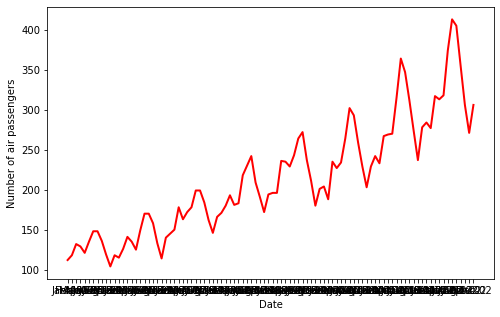

In [8]:
# Lineplot for Passengers
plt.figure(figsize=(8,5))
plt.xlabel("Date")
plt.ylabel("Number of air passengers")
ax = plt.axes()
ax.set_facecolor("white")
plt.plot(data['Passengers'], color = 'red', linewidth=2)

<AxesSubplot:>

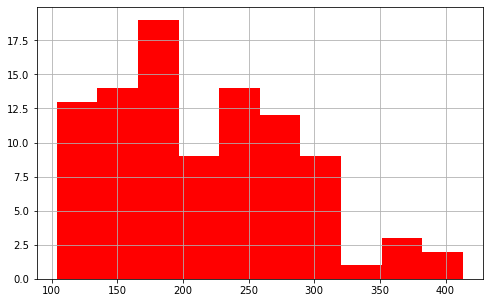

In [9]:
ax = plt.axes()
ax.set_facecolor("white")
data['Passengers'].hist(figsize=(8,5), color = 'red')

<AxesSubplot:ylabel='Density'>

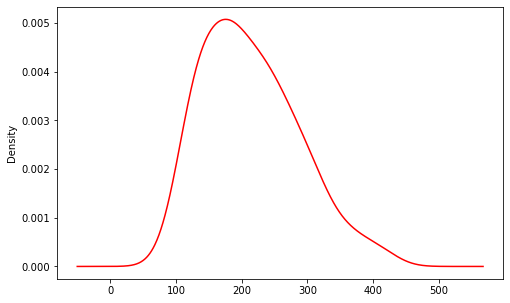

In [10]:
# Density Plot
ax = plt.axes()
ax.set_facecolor("white")
data['Passengers'].plot(kind = 'kde', figsize=(8,5), color = 'red')

In [ ]:
#Passengers data is somewhat normally distributed

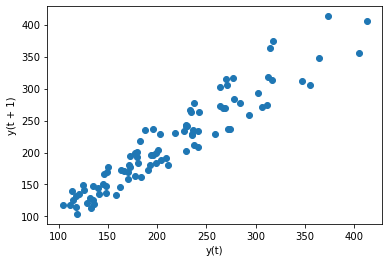

In [12]:
# Lagplot
from pandas.plotting import lag_plot

lag_plot(data['Passengers'])
ax = plt.axes()
ax.set_facecolor("white")
plt.show()

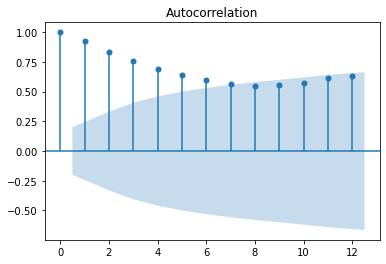

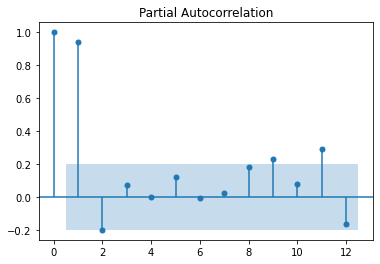

In [13]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Passengers,lags=12)
ax = plt.axes()
ax.set_facecolor("white")
tsa_plots.plot_pacf(data.Passengers,lags=12)
ax = plt.axes()
ax.set_facecolor("white")
plt.show()

In [ ]:
#Data Driven Forecasting Methods

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [15]:
# Splitting data into Train and Test (77/33)
Train = data.head(84)
Test = data.tail(12)


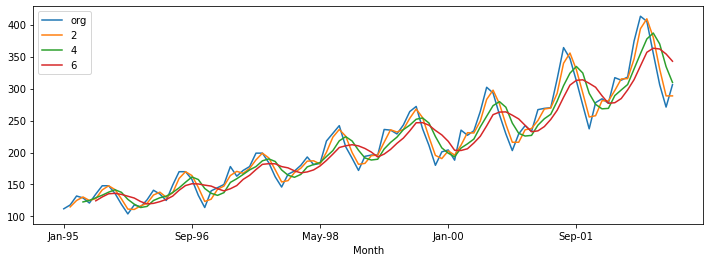

In [16]:
#Moving Average Method
plt.figure(figsize=(12,4))
data.Passengers.plot(label="org")
for i in range(2,8,2):
    data["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

In [ ]:
#With windows = 2, we are getting less deviation of the forecasting values with original values

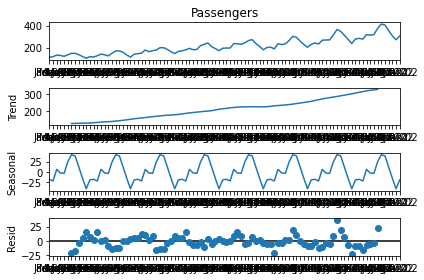

In [17]:
#Time series decomposition plot
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_ts_add = seasonal_decompose(data.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

In [18]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

In [30]:
#Model based Forecasting Methods
# Data preprocessing for models
data1 = data.copy()
data1.head()

,Passengers
Month,
Jan-95,112
Feb-95,118
Mar-95,132
Apr-95,129
May-95,121


In [31]:
data1["t"] = np.arange(1,97)
data1["t_squared"] = data1["t"]*data1["t"]

data1["log_psngr"] = np.log(data1["Passengers"])

data1.head()

,Passengers,t,t_squared,log_psngr
Month,,,,
Jan-95,112,1,1,4.718499
Feb-95,118,2,4,4.770685
Mar-95,132,3,9,4.882802
Apr-95,129,4,16,4.859812
May-95,121,5,25,4.795791


In [32]:
# Splitting data into Train and Test (77/33)
Train = data1.head(84)
Test = data1.tail(12)

In [33]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear_model = RMSE(Test['Passengers'], pred_linear)
rmse_linear_model

53.19923653480269

In [35]:
#Exponential Model
Exp = smf.ols('log_psngr~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp_model = RMSE(Test['Passengers'], np.exp(pred_Exp))
rmse_Exp_model

46.057361103156246

In [36]:
#Quadratic Model
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad_model = RMSE(Test['Passengers'], pred_Quad)
rmse_Quad_model

48.05188897933099

In [ ]:
#ARIMA model


In [37]:
series = data.copy()

In [38]:

series

,Passengers
Month,
Jan-95,112
Feb-95,118
Mar-95,132
Apr-95,129
May-95,121
...,...
Aug-02,405
Sep-02,355
Oct-02,306


In [39]:
# separate out a validation dataset
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 84, Validation 12


In [ ]:
#Persistence/ Base model

In [40]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.715)
train, test = X[0:train_size], X[train_size:]

In [41]:
print(train.shape)
print(test.shape)

(60,)
(24,)


In [42]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>Predicted=229.000, Expected=203.000
>Predicted=203.000, Expected=229.000
>Predicted=229.000, Expected=242.000
>Predicted=242.000, Expected=233.000
>Predicted=233.000, Expected=267.000
>Predicted=267.000, Expected=269.000
>Predicted=269.000, Expected=270.000
>Predicted=270.000, Expected=315.000
>Predicted=315.000, Expected=364.000
>Predicted=364.000, Expected=347.000
>Predicted=347.000, Expected=312.000
>Predicted=312.000, Expected=274.000
>Predicted=274.000, Expected=237.000
>Predicted=237.000, Expected=278.000
RMSE: 29.058


In [43]:
rmse_Persistence_model = 29.058

In [ ]:
#ARIMA Hyperparameters

In [45]:
series = pd.read_csv('Airlines+Data.csv', header=0, index_col=0, parse_dates=True)

In [46]:
series

,Passengers
Month,
Jan-95,112
Feb-95,118
Mar-95,132
Apr-95,129
May-95,121
...,...
Aug-02,405
Sep-02,355
Oct-02,306


In [47]:
# separate out a validation dataset
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 84, Validation 12


In [48]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [52]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.715)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [53]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [54]:
# load dataset
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=87.974
ARIMA(0, 0, 1) RMSE=49.107
ARIMA(0, 1, 0) RMSE=29.116
ARIMA(0, 1, 1) RMSE=28.328
ARIMA(0, 1, 2) RMSE=30.666
ARIMA(0, 1, 3) RMSE=26.562
ARIMA(0, 1, 4) RMSE=24.650
ARIMA(0, 2, 0) RMSE=35.791
ARIMA(0, 2, 1) RMSE=29.844
ARIMA(0, 2, 2) RMSE=28.876
ARIMA(0, 2, 3) RMSE=29.171
ARIMA(0, 2, 4) RMSE=27.479
ARIMA(1, 0, 0) RMSE=29.596
ARIMA(1, 0, 1) RMSE=28.465
ARIMA(1, 0, 2) RMSE=127.343
ARIMA(1, 1, 0) RMSE=28.830
ARIMA(1, 1, 1) RMSE=27.792
ARIMA(1, 1, 2) RMSE=25.304
ARIMA(1, 2, 0) RMSE=35.272
ARIMA(2, 0, 0) RMSE=29.093
ARIMA(2, 1, 0) RMSE=28.255
ARIMA(2, 1, 1) RMSE=25.236
ARIMA(2, 2, 0) RMSE=33.534
ARIMA(3, 0, 0) RMSE=28.707
ARIMA(3, 0, 1) RMSE=28.653
ARIMA(3, 1, 0) RMSE=28.832
ARIMA(3, 1, 1) RMSE=25.625
ARIMA(3, 2, 0) RMSE=34.396
ARIMA(4, 0, 0) RMSE=29.279
ARIMA(4, 1, 0) RMSE=27.755
ARIMA(4, 1, 1) RMSE=26.573
ARIMA(4, 2, 0) RMSE=32.502
ARIMA(4, 2, 1) RMSE=28.363
Best ARIMA(0, 1, 4) RMSE=24.650


In [65]:
rmse_ARIMA_model = 24.650

In [ ]:
#Build Model based on the optimized values

In [55]:
# load data
train = pd.read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

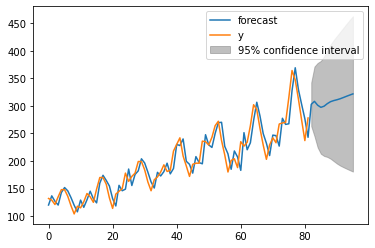

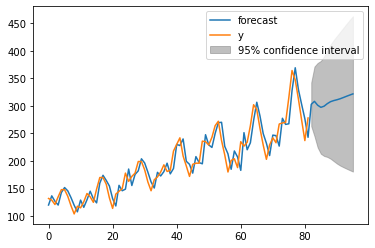

In [56]:
# fit model
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1, 96)

In [57]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

51.13510512335608

In [ ]:
#Combine train and test data and build final model

In [59]:
# fit model
data = pd.read_csv('Airlines+Data.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [60]:
model = ARIMA(X, order=(0,1,4))
model_fit = model.fit()

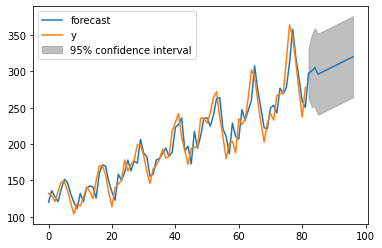

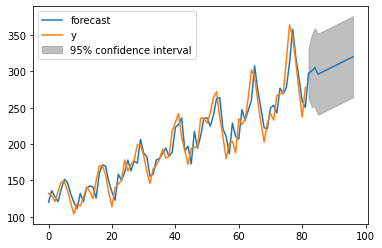

In [61]:
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,97)

In [62]:
forecast

array([297.29505349, 300.66283692, 305.18876735, 296.16875215,
       298.3391288 , 300.50950545, 302.67988211, 304.85025876,
       307.02063541, 309.19101207, 311.36138872, 313.53176538])

In [66]:
list = [['Linear Mode',rmse_linear_model],['Exp model',rmse_Exp_model],['Quad model',rmse_Quad_model],
    ['Persistence/ Base model', rmse_Persistence_model], ['ARIMA Model', rmse_ARIMA_model]]

In [67]:
df = pd.DataFrame(list, columns =['Model', 'RMSE_Value']) 
df

,Model,RMSE_Value
0,Linear Mode,53.199237
1,Exp model,46.057361
2,Quad model,48.051889
3,Persistence/ Base model,29.058000
4,ARIMA Model,24.650000


In [ ]:
#We can see that, we are getting lowest RMSE value for the ARIMA model